In [12]:
# organize imports
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import normalize
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
import keras.backend as K
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import random
import pydot
import tensorflow as tf


Using TensorFlow backend.


In [13]:
# seed for reproducing same results
seed = 9
np.random.seed(seed)


# Train on the Lagrange multipliers

In [109]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals2.jld2", "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_train))
print(np.shape(Y_test))
Y_train = Y_train[:, 180:186]
Y_test = Y_test[:, 180:186]
print(np.shape(Y_train))
print(np.shape(Y_test))

(X_train, X_test, Y_train, Y_test, xMin, xRange, yMin, yRange) = normalize_datasets(X_train, X_test, Y_train, Y_test)

filename = "NoObstacleDualParams.h5"
saveDataParamsToHDF5(filename, xMin, yMin, xRange, yRange)

(2011, 188)
(671, 188)
(2011, 186)
(671, 186)
(2011, 6)
(671, 6)


In [37]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])

(X_train, X_test, Y_train, Y_test, xMin, xRange, yMin, yRange) = normalize_datasets(X_train, X_test, Y_train, Y_test)

filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
saveDataParamsToHDF5(filename, xMin, yMin, xRange, yRange)


In [110]:
# create the model
model = Sequential()
model.add(Dense(512, input_dim=188, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(6, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

In [111]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 2011 samples, validate on 671 samples
Epoch 1/30
2011/2011 [==============================] - 66s 33ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Learning rate:  0.001
Epoch 2/30
2011/2011 [==============================] - 72s 36ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Learning rate:  0.001
Epoch 3/30
2011/2011 [==============================] - 74s 37ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Learning rate:  0.001
Epoch 4/30
2011/2011 [==============================] - 75s 37ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Learning rate:  0.000100000005
Epoch 5/30
2011/2011 [==============================] - 76s 38ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Learning rate:  0.00010000

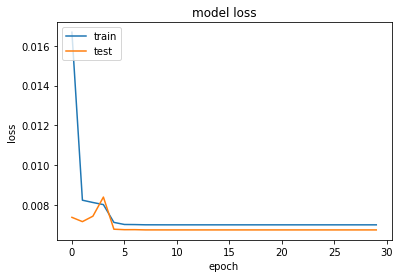

In [112]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

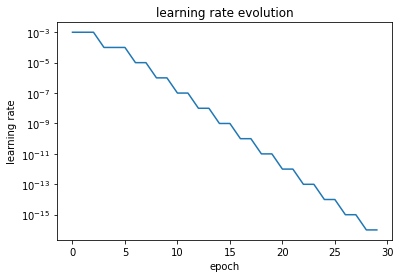

In [113]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [114]:
# save model to hdf5 file
model.save('NoObstacleDualMoreEpochs.h5') 

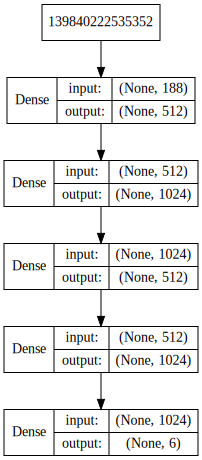

In [32]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('NoObstacleDualMoreEpochs.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [31]:
model = load_model('NoObstacleDualMoreEpochs.h5')

# serialize model to JSON
model_json = model.to_json()
with open("NoObstacleDualMoreEpochs.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NoObstacleDualWeightsMoreEpochs.h5")
print("Saved model to disk")

file = h5py.File('NoObstacleDualWeightsMoreEpochs.h5', 'r')
list(file.keys())

OSError: Unable to create file (unable to truncate a file which is already open)

# Visualize the training (and test) dataset

### Zero final velocity dataset with only first iterations of GuSTO stored

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training data
Random i = 340


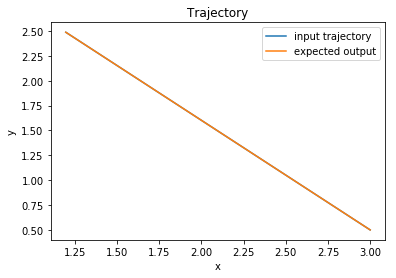

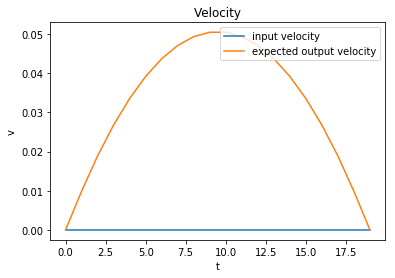

Random i = 106


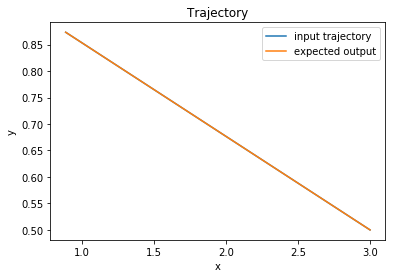

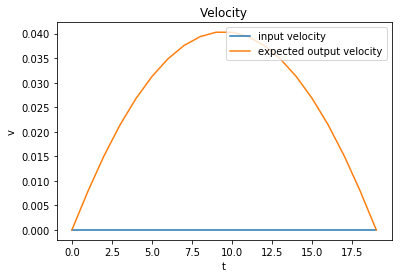

Random i = 295


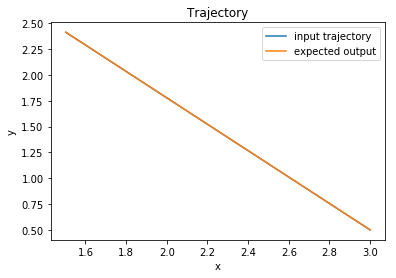

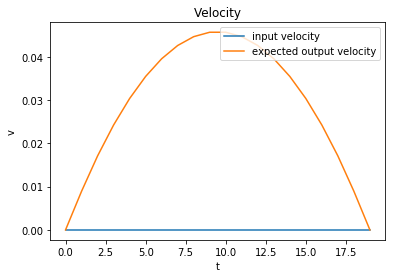

Random i = 260


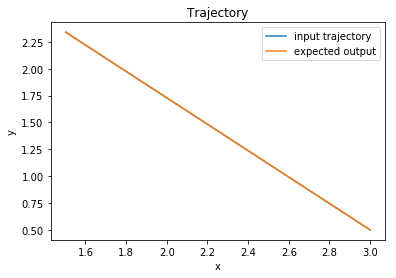

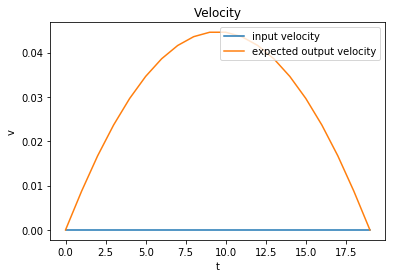

Random i = 447


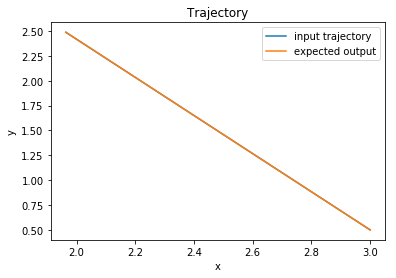

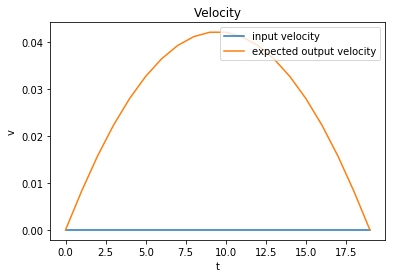

Random i = 24


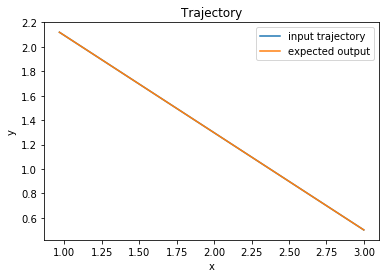

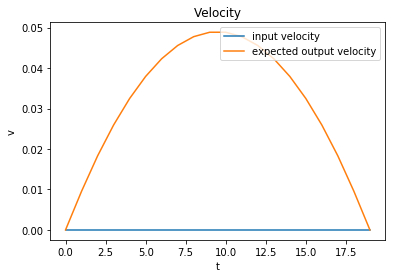

Random i = 292


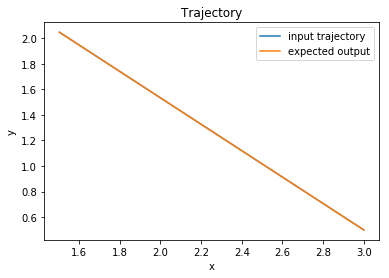

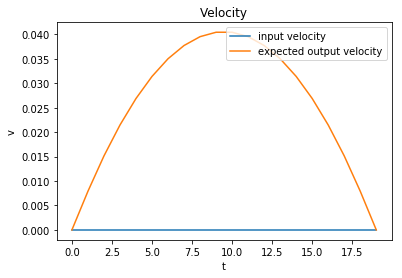

Random i = 365


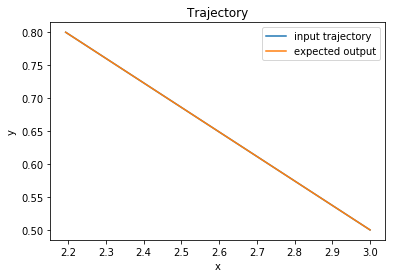

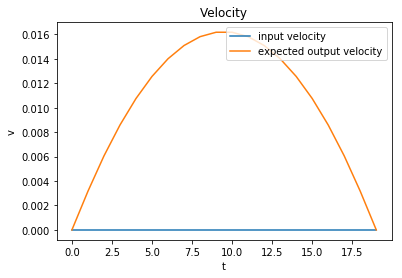

Test data
Random i = 119


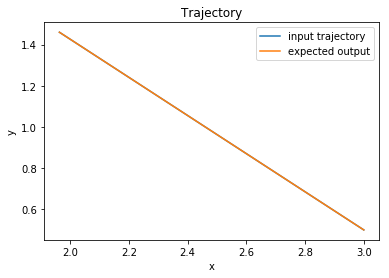

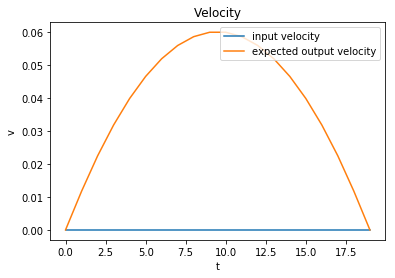

Random i = 32


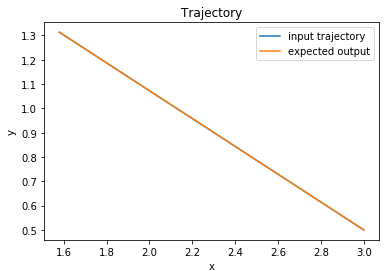

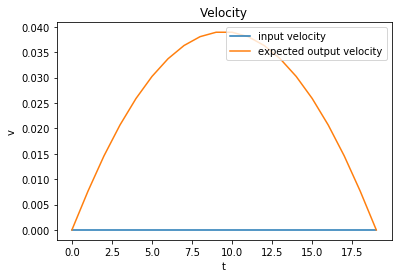

Random i = 130


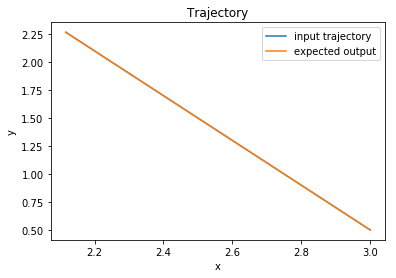

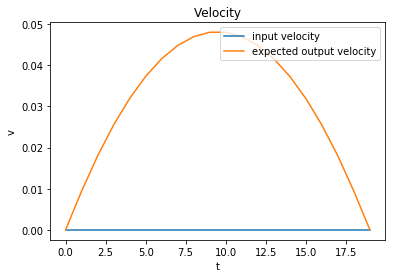

Random i = 156


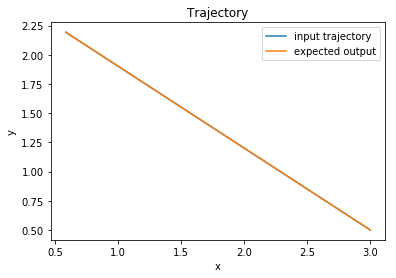

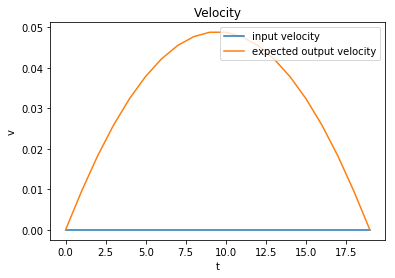

Random i = 10


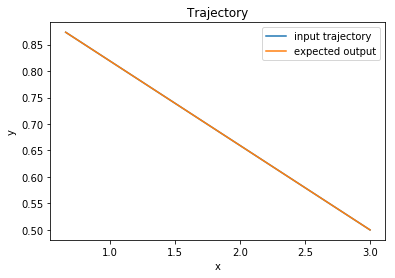

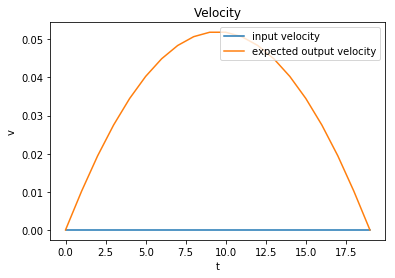

Random i = 52


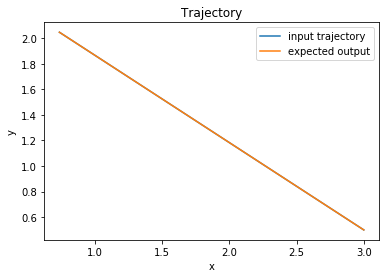

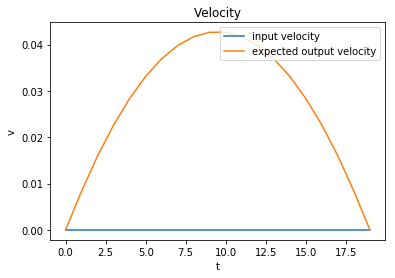

Random i = 139


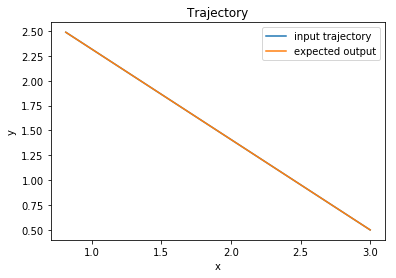

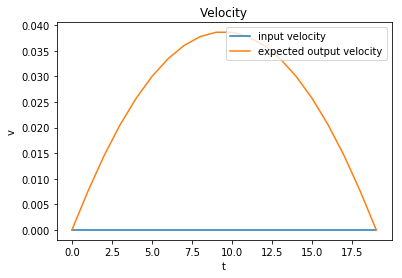

Random i = 12


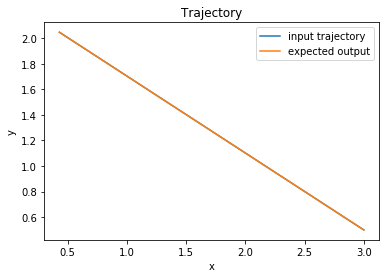

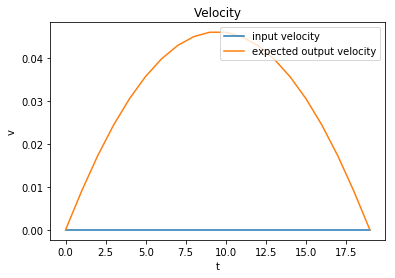

In [13]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

print("Training data")
for x in range(8):
    i = random.randint(1,np.size(X_train,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])
print("Test data")
for x in range(8):
    i = random.randint(1,np.size(X_test,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_test[i,:],Y_test[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])



## Note that the xy trajectory always remains a straight line and the velocity changes from a constant zero to a parabolic curve

# Try to overfit data! Bigger network and dataset with zero final velocity

In [14]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
print(np.shape(X_train))
print(np.shape(X_test))
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])
print(np.shape(X_train))
print(np.shape(X_test))

(484, 182)
(162, 182)
(1453, 182)
(485, 182)


In [ ]:
SingleObstacleFirst5Iter.jld2

# Single obstacle dataset with zero final velocity

In [27]:
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])
# Normalize all datasets to be between [0,1]
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])

xMin = np.amin(X, axis=0)
xMax = np.amax(X, axis=0)
xRange = xMax - xMin
xRange[xRange == 0] = 1.0
xRange[abs(xRange) <1.0e-20]=1.0
X_train = (X_train-xMin)/xRange
X_test = (X_test-xMin)/xRange

yMin = np.amin(Y, axis=0)
yMax = np.amax(Y, axis=0)
yRange = yMax - yMin
yRange[yRange == 0] = 1.0
yRange[abs(yRange) <1.0e-20]=1.0
Y_train = (Y_train-yMin)/yRange
Y_test = (Y_test-yMin)/yRange

# Save a dictionary of xMin, xRange, yMin, yRange into a pickle file.
import pickle
# data_params = { "xMin": xMin }

data_params = { "xMin": xMin, "xRange": xRange, "yMin": yMin, "yRange": yRange }
f = open( "SingleObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.p", "wb" )
pickle.dump(data_params, f,-1)
f.close() 


In [28]:
# create the model
model = Sequential()
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

In [29]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=3, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 978 samples, validate on 327 samples
Epoch 1/30
978/978 [==============================] - 24s 25ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Learning rate:  0.001
Epoch 2/30
978/978 [==============================] - 10s 11ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Learning rate:  0.001
Epoch 3/30
978/978 [==============================] - 11s 11ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Learning rate:  0.001
Epoch 4/30
978/978 [==============================] - 11s 11ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Learning rate:  0.001
Epoch 5/30
978/978 [==============================] - 12s 12ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Learning rate:  0.001
Epoch 6/30
978/978 [====

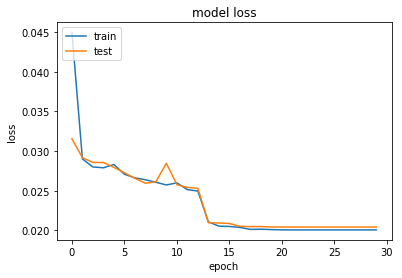

In [30]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

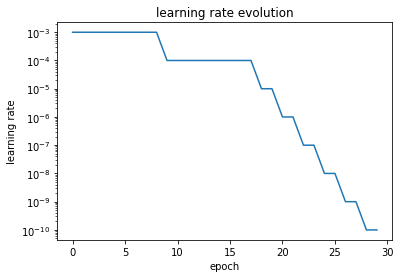

In [31]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [32]:
# save model to hdf5 file
model.save('SingleObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalized.h5') 

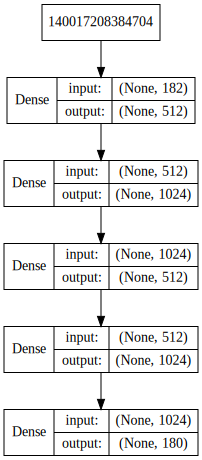

In [33]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('SingleObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalized.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Single obstacle dataset

In [11]:
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])
# Normalize all datasets to be between [0,1]
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])

xMin = np.amin(X, axis=0)
xMax = np.amax(X, axis=0)
xRange = xMax - xMin
xRange[xRange == 0] = 1.0
xRange[abs(xRange) <1.0e-20]=1.0
X_train = (X_train-xMin)/xRange
X_test = (X_test-xMin)/xRange

yMin = np.amin(Y, axis=0)
yMax = np.amax(Y, axis=0)
yRange = yMax - yMin
yRange[yRange == 0] = 1.0
yRange[abs(yRange) <1.0e-20]=1.0
Y_train = (Y_train-yMin)/yRange
Y_test = (Y_test-yMin)/yRange

# Save a dictionary of xMin, xRange, yMin, yRange into a pickle file.
import pickle
# data_params = { "xMin": xMin }

data_params = { "xMin": xMin, "xRange": xRange, "yMin": yMin, "yRange": yRange }
f = open( "SingleObstacleFirst5IterParams.p", "wb" )
pickle.dump(data_params, f,-1)
f.close() 


/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [12]:
# create the model
model = Sequential()
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=3, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Instructions for updating:
Use tf.cast instead.
Train on 2986 samples, validate on 996 samples
Epoch 1/30
2986/2986 [==============================] - 37s 12ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Learning rate:  0.001
Epoch 2/30
2986/2986 [==============================] - 40s 13ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Learning rate:  0.001
Epoch 3/30
2986/2986 [==============================] - 40s 13ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Learning rate:  0.001
Epoch 4/30
2986/2986 [==============================] - 40s 14ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Learning rate:  0.001
Epoch 5/30
2986/2986 [==============================] - 42s 14ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0091 - val_mean_squared_e

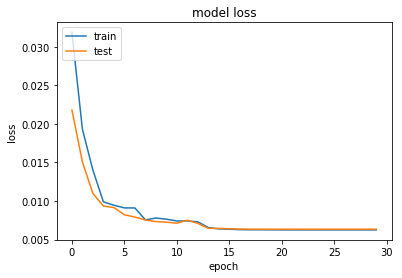

In [18]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

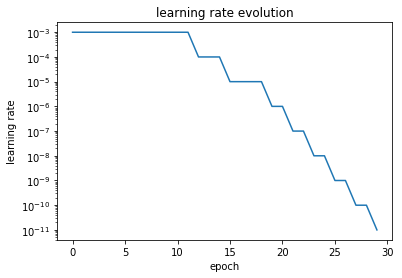

In [19]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [20]:
# save model to hdf5 file
model.save('SingleObstacleFirst5IterNormalized.h5') 

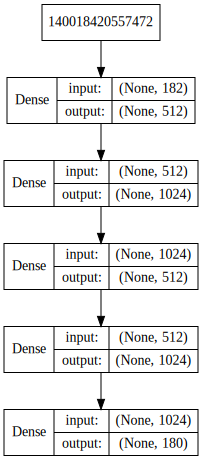

In [21]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('SingleObstacleFirst5IterNormalized.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# All iterations dataset

In [37]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])

(X_train, X_test, Y_train, Y_test, xMin, xRange, yMin, yRange) = normalize_datasets(X_train, X_test, Y_train, Y_test)

filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
saveDataParamsToHDF5(filename, xMin, yMin, xRange, yRange)


In [19]:
# create the model
model = Sequential()
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Instructions for updating:
Use tf.cast instead.
Train on 1453 samples, validate on 485 samples
Epoch 1/30
1453/1453 [==============================] - 47s 32ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Learning rate:  0.001
Epoch 2/30
1453/1453 [==============================] - 55s 38ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Learning rate:  0.001
Epoch 3/30
1453/1453 [==============================] - 58s 40ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Learning rate:  0.001
Epoch 4/30
1453/1453 [==============================] - 58s 40ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Learning rate:  0.001
Epoch 5/30
1453/1453 [==============================] - 59s 41ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0249 - val_mean_squared_e

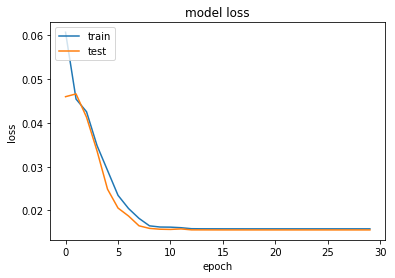

In [21]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

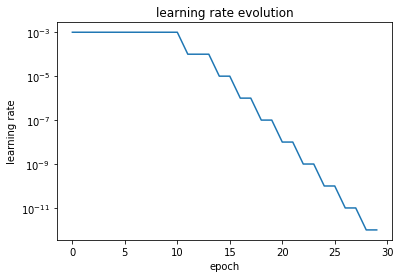

In [22]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [23]:
# save model to hdf5 file
model.save('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.h5') 

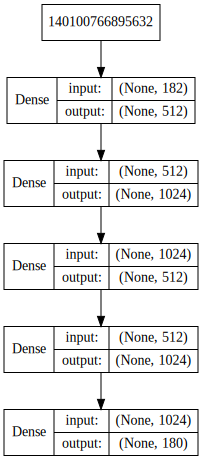

In [24]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [6]:
model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.h5')

# serialize model to JSON
model_json = model.to_json()
with open("NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedBWeights.h5")
print("Saved model to disk")

file = h5py.File('SingleObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalized.h5', 'r')
list(file.keys())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Saved model to disk


['model_weights', 'optimizer_weights']

# Only first iteration dataset

In [25]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
# Normalize all datasets to be between [0,1]
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])

xMin = np.amin(X, axis=0)
xMax = np.amax(X, axis=0)
xRange = xMax - xMin
xRange[xRange == 0] = 1.0
xRange[abs(xRange) <1.0e-20]=1.0
X_train = (X_train-xMin)/xRange
X_test = (X_test-xMin)/xRange

yMin = np.amin(Y, axis=0)
yMax = np.amax(Y, axis=0)
yRange = yMax - yMin
yRange[yRange == 0] = 1.0
yRange[abs(yRange) <1.0e-20]=1.0
Y_train = (Y_train-yMin)/yRange
Y_test = (Y_test-yMin)/yRange

# Save a dictionary of xMin, xRange, yMin, yRange into a pickle file.
import pickle
# data_params = { "xMin": xMin }

data_params = { "xMin": xMin, "xRange": xRange, "yMin": yMin, "yRange": yRange }
f = open( "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterParams.p", "wb" )
pickle.dump(data_params, f,-1)
f.close() 


In [ ]:
# create the model
model = Sequential()
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

In [14]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Instructions for updating:
Use tf.cast instead.
Train on 484 samples, validate on 162 samples
Epoch 1/30
484/484 [==============================] - 38s 79ms/step - loss: 0.0947 - mean_squared_error: 0.0947 - val_loss: 0.0586 - val_mean_squared_error: 0.0586
Learning rate:  0.001
Epoch 2/30
484/484 [==============================] - 41s 84ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Learning rate:  0.001
Epoch 3/30
484/484 [==============================] - 42s 87ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Learning rate:  0.001
Epoch 4/30
484/484 [==============================] - 39s 81ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Learning rate:  0.001
Epoch 5/30
484/484 [==============================] - 43s 89ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 0.0319 - val_mean_squared_error: 0.031

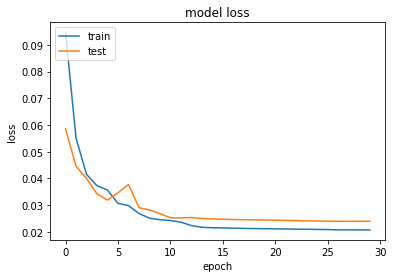

In [15]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

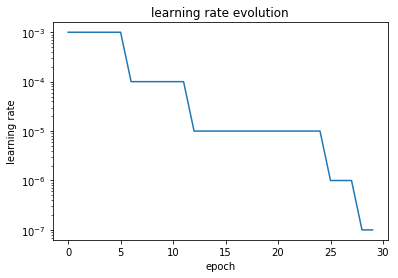

In [16]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [17]:
# save model to hdf5 file
model.save('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterNormalizedA.h5') 

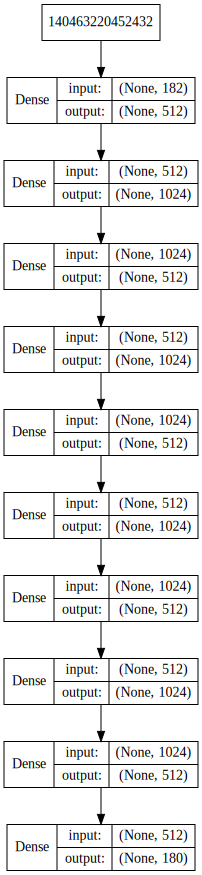

In [31]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterNormalizedA.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Previous run

In [22]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

# Overfit to exactly 2 samples!
# numSamples = 30
# X_train = X_train[0:numSamples,:]
# X_test = X_test[0:numSamples,:]
# Y_train = Y_train[0:numSamples,:]
# Y_test = Y_test[0:numSamples,:]

# Normalize all datasets to be between [0,1]
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])

xMin = np.amin(X, axis=0)
xMax = np.amax(X, axis=0)
xRange = xMax - xMin
xRange[xRange == 0] = 1.0

X_train = (X_train-xMin)/xRange
X_test = (X_test-xMin)/xRange

yMin = np.amin(Y_train, axis=0)
yMax = np.amax(Y_train, axis=0)
yRange = yMax - yMin
yRange[yRange == 0] = 1.0

Y_train = (Y_train-yMin)/yRange
Y_test = (Y_test-yMin)/yRange


# What's weird is that if you make X_train a (1,182) vector of random numbers betweeen (-1,1) 
# and Y_train the original vector, the loss stops at 0.0010 or 0.0012 and won't go down

# Switch to tanh activation and the loss stops going down at 0.0214

# tanh just seems horrible. Even with y_train as all zeros, the loss stops at 0.0060 
# whereas for relu with y_train as all zeros, we get 1e-6 range loss

# using last layer as linear with y_train as initial makes the loss stop at 2.68e-4
# adding another layer at end as linear makes loss go to 1e-4

# I can use 1 sample of X_train with 2 ending linear layers and  make the loss stop at 2.81e-4

# All linear makes it go to 0.0016

# alternating relu and linear is 2.56e-4

# double size (layers) network is 2.0248e-4

# Now I normalized the Y_train values to be between 0 and 1. Kept the double size relu linear layers 
# and tried 30 samples. Loss stops at 0.0635

# Changed network so all layers are relu. Again tried 30 samples. Loss stops at 0.0901

# Added a few layers. Loss stops going down at 0.0886

# Put in all the samples. Loss stop at 0.0468

# Also normalized x now. Loss drops to 0.03 after a few epochs.

# create the model
model = Sequential()
# model.add(Dense(512, input_dim=182, activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(180, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, input_dim=182, activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

In [14]:
# (X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
# # Overfit to exactly 2 samples!
# numSamples = 2
# X_train = X_train[1:numSamples,:]
# # X_test = X_test[1:4,:]
# Y_train = Y_train[1:numSamples,:]
# # Y_test = Y_test[1:4,:]

# # create the model
# model = Sequential()
# model.add(Dense(512, input_dim=182, activation='relu'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# # compile the model
# customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=1, min_lr=1e-50)

# lrHist = []

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 484 samples, validate on 162 samples
Epoch 1/30
484/484 [==============================] - 34s 71ms/step - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0872 - val_mean_squared_error: 0.0872
Learning rate:  0.001
Epoch 2/30
 96/484 [====>.........................] - ETA: 32s - loss: 0.0788 - mean_squared_error: 0.0788

KeyboardInterrupt: 

In [ ]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [16]:
# save model to hdf5 file
# model.save('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterNormalized.h5') 

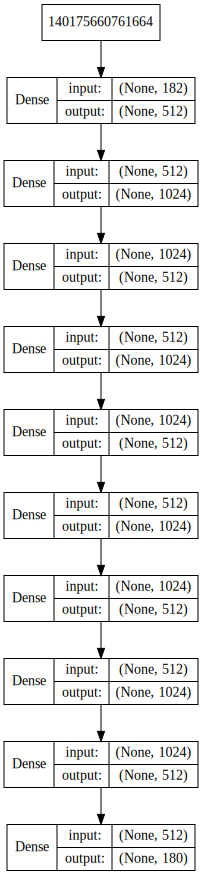

In [24]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterNormalized.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Run model on some inputs and plot results

In [ ]:
NoObstacleDualWeights

## No obstacle with lagrange multipliers- more epochs

### Try training data

In [35]:
model = load_model('NoObstacleDualMoreEpochs.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals2.jld2", "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])

filename = "NoObstacleDualParams.h5"
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5(filename)

Idx = [0,1,2,3,1000]
X_train_np_array=np.array(X_train)
NN_input = (X_train_np_array-xMin)/xRange
NN_output = model.predict(NN_input[Idx])
NN_output = NN_output*yRange + yMin

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training Examples


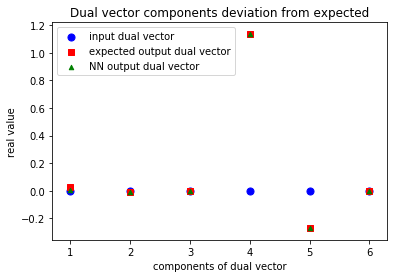

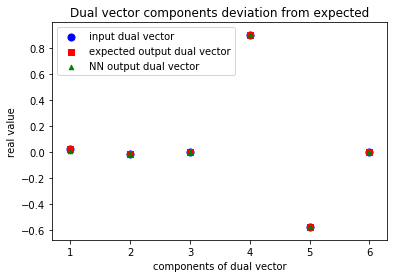

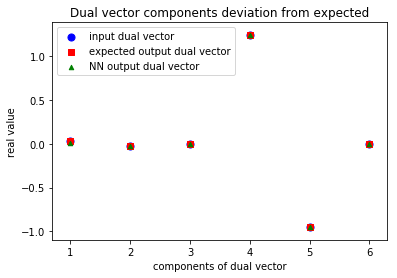

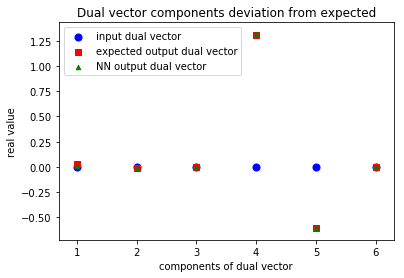

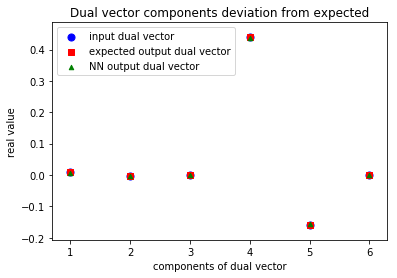

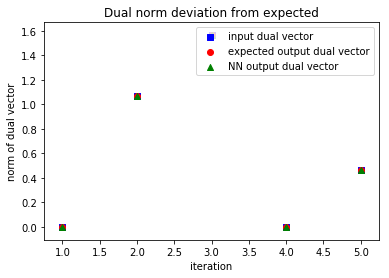

In [46]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    X_dual = X_train[train_idx,182:188]
    Y_dual = Y_train[train_idx,180:186]
    NN_dual = NN_output[NN_idx,:]
    plotLagrangeInputExpectedAndNNSingle(X_dual, Y_dual, NN_dual)
    print("")

X_duals = [X_train[i,182:188] for i in Idx]
Y_duals = [Y_train[i,180:186] for i in Idx]
NN_duals = NN_output

plotLagrangeInputExpectedAndNN(X_duals, Y_duals, NN_duals)

### Try test data

In [47]:
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

Test Examples


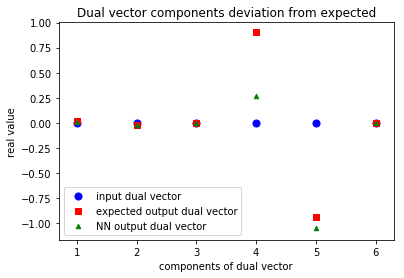

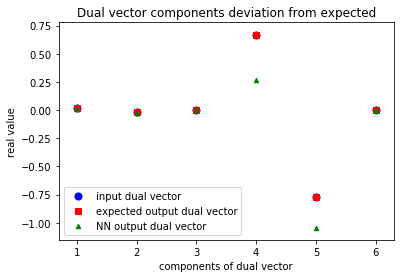

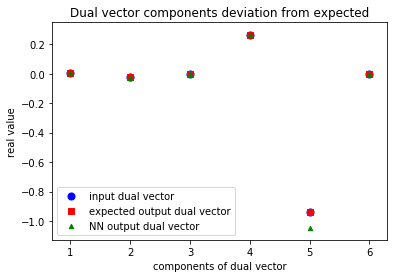

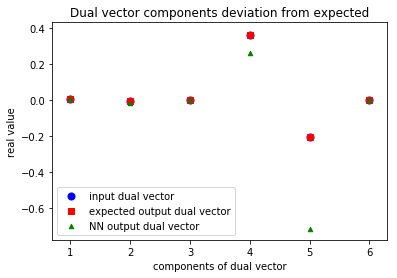

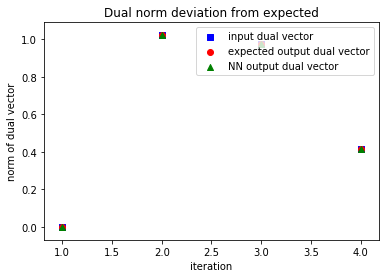

In [50]:
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    X_dual = X_test[test_idx,182:188]
    Y_dual = Y_test[test_idx,180:186]
    NN_dual = NN_output[NN_idx,:]
    plotLagrangeInputExpectedAndNNSingle(X_dual, Y_dual, NN_dual)
    print("")

X_duals = [X_test[i,182:188] for i in Idx]
Y_duals = [Y_test[i,180:186] for i in Idx]
NN_duals = NN_output

plotLagrangeInputExpectedAndNN(X_duals, Y_duals, NN_duals)

## No obstacle with lagrange multipliers

### Try training data

In [76]:
model = load_model('NoObstacleDual.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals2.jld2", "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])

filename = "NoObstacleDualParams.h5"
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5(filename)

Idx = [0,1,2,3,1000]
X_train_np_array=np.array(X_train)
NN_input = (X_train_np_array-xMin)/xRange
NN_output = model.predict(NN_input[Idx])
NN_output = NN_output*yRange + yMin

Training Examples


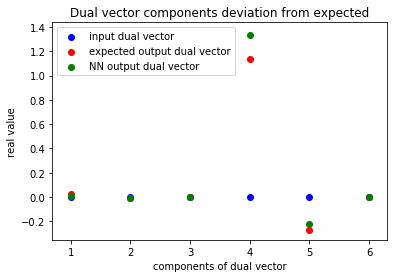

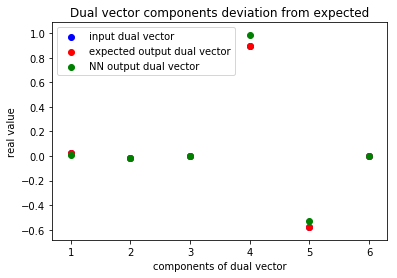

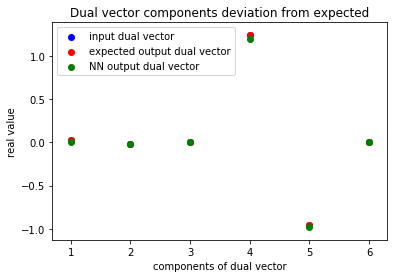

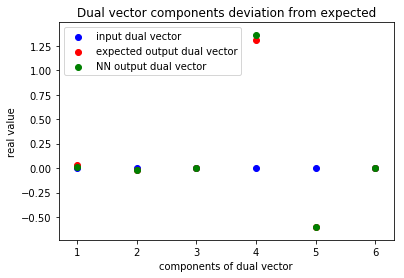

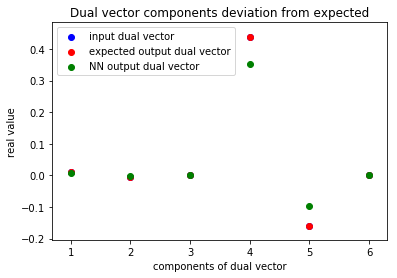

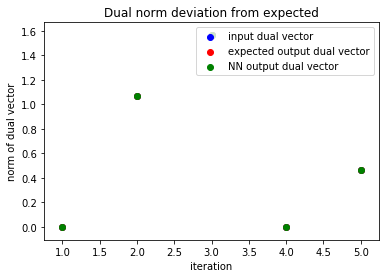

In [106]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    X_dual = X_train[train_idx,182:188]
    Y_dual = Y_train[train_idx,180:186]
    NN_dual = NN_output[NN_idx,:]
    plotLagrangeInputExpectedAndNNSingle(X_dual, Y_dual, NN_dual)
    print("")

X_duals = [X_train[i,182:188] for i in Idx]
Y_duals = [Y_train[i,180:186] for i in Idx]
NN_duals = NN_output

plotLagrangeInputExpectedAndNN(X_duals, Y_duals, NN_duals)

### Try test data

In [107]:
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

Test Examples


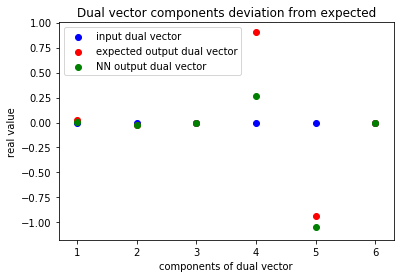

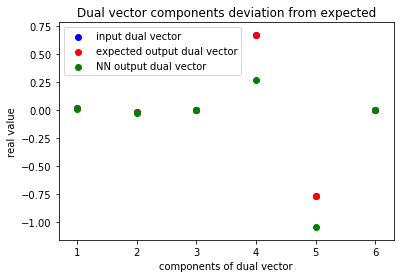

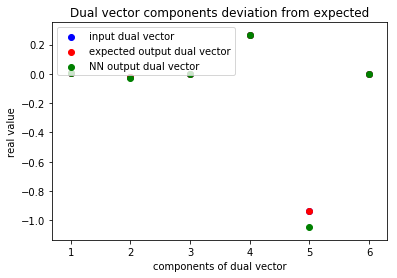

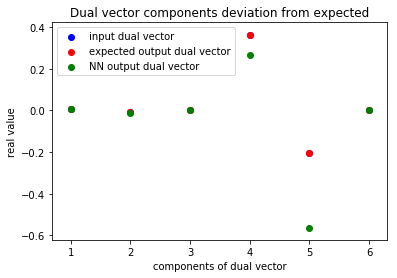

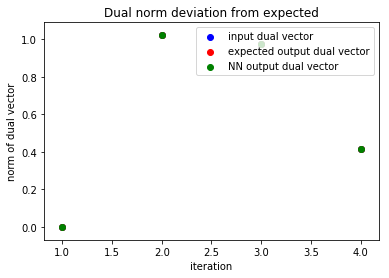

In [108]:
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    X_dual = X_test[test_idx,182:188]
    Y_dual = Y_test[test_idx,180:186]
    NN_dual = NN_output[NN_idx,:]
    plotLagrangeInputExpectedAndNNSingle(X_dual, Y_dual, NN_dual)
    print("")

X_duals = [X_test[i,182:188] for i in Idx]
Y_duals = [Y_test[i,180:186] for i in Idx]
NN_duals = NN_output

plotLagrangeInputExpectedAndNN(X_duals, Y_duals, NN_duals)

## Single obstacle Model new data with normalization

### Try training data

In [35]:
model = load_model('SingleObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalized.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])
f = open( "SingleObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.p", "rb" )
params_dict = pickle.load(f)         
f.close() 
xMin = params_dict["xMin"]
yMin = params_dict["yMin"]
xRange = params_dict["xRange"]
yRange = params_dict["yRange"]


Idx = [0,1,2]
X_train_np_array=np.array(X_train)
NN_input = (X_train_np_array-xMin)/xRange
NN_output = model.predict(NN_input[Idx])
NN_output = NN_output*yRange + yMin

Training Examples


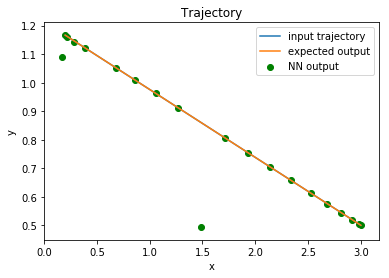

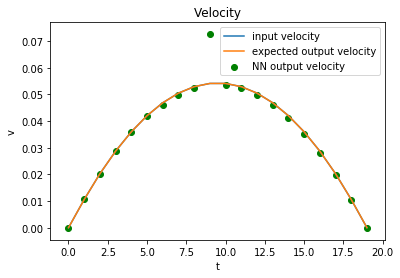

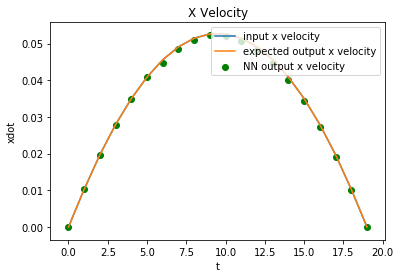

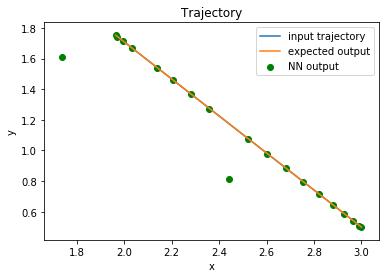

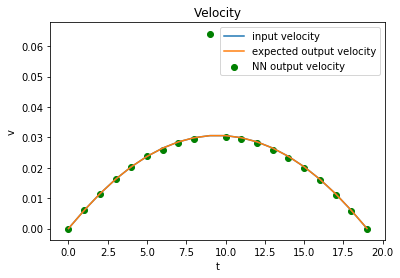

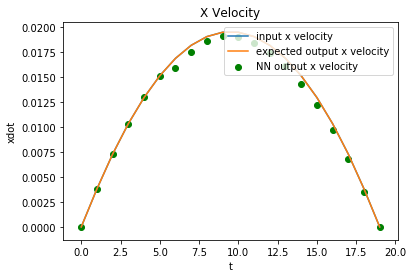

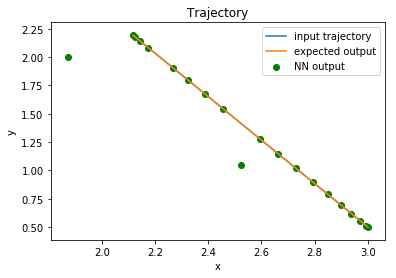

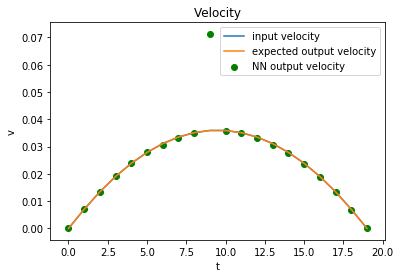

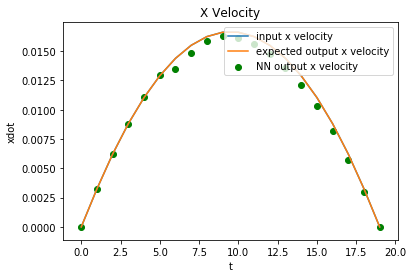

In [36]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotXVelocityInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])



### Try test data

In [37]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

(4, 180)
Test Examples


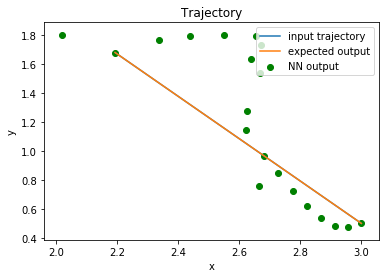

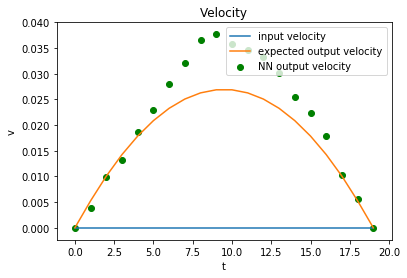

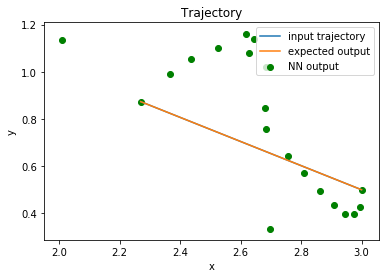

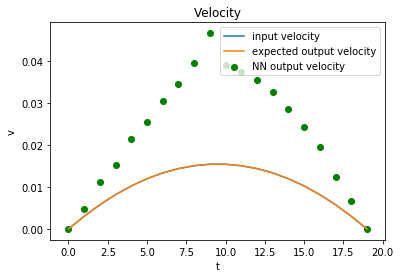

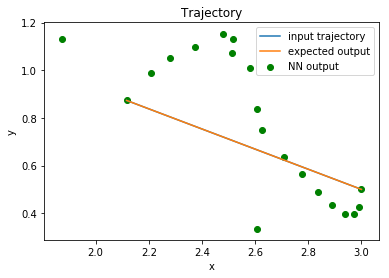

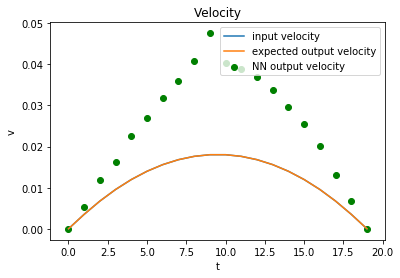

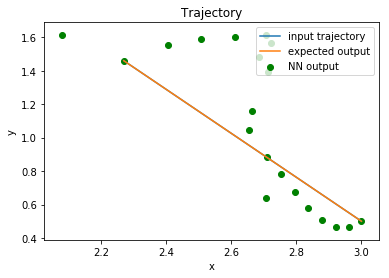

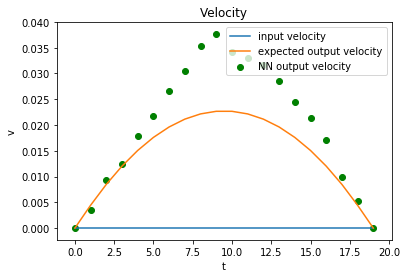

In [38]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


## Single obstacle Model with normalization

### Try training data

In [22]:
model = load_model('SingleObstacleFirst5IterNormalized.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])
f = open( "SingleObstacleFirst5IterParams.p", "rb" )
params_dict = pickle.load(f)         
f.close() 
xMin = params_dict["xMin"]
yMin = params_dict["yMin"]
xRange = params_dict["xRange"]
yRange = params_dict["yRange"]


Idx = [0,1,2]
X_train_np_array=np.array(X_train)
NN_input = (X_train_np_array-xMin)/xRange
NN_output = model.predict(NN_input[Idx])
NN_output = NN_output*yRange + yMin

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training Examples


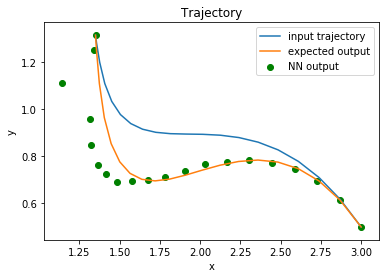

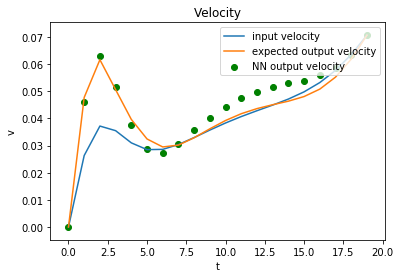

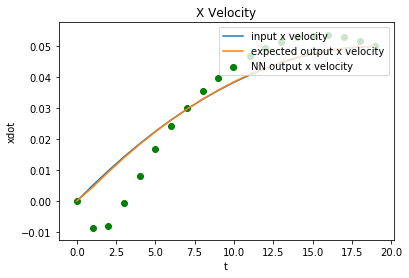

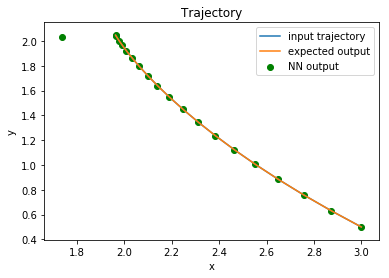

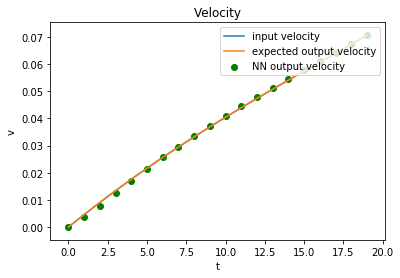

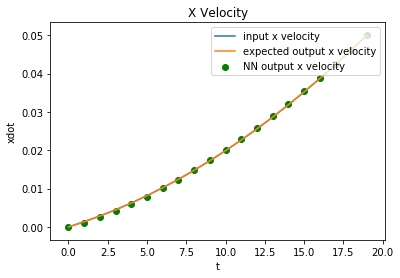

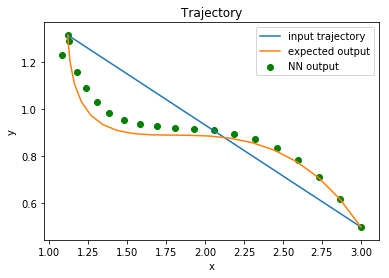

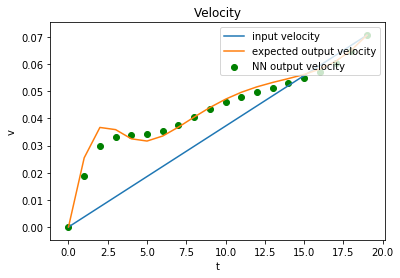

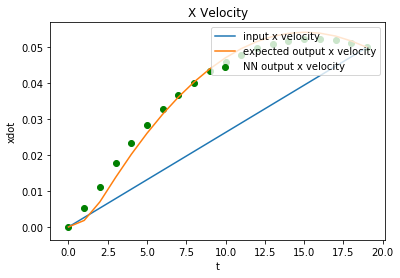

In [23]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotXVelocityInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])



### Try test data

In [24]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

(4, 180)
Test Examples


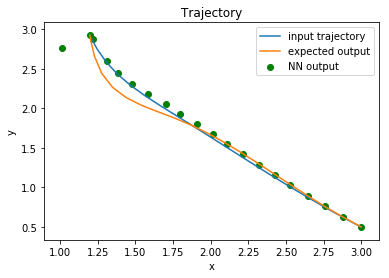

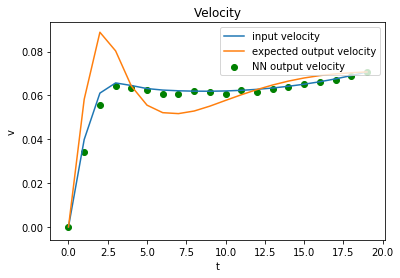

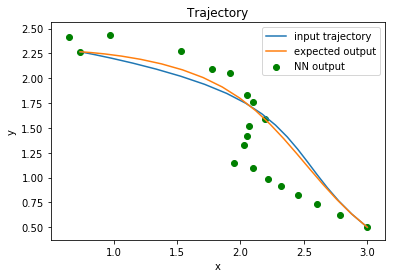

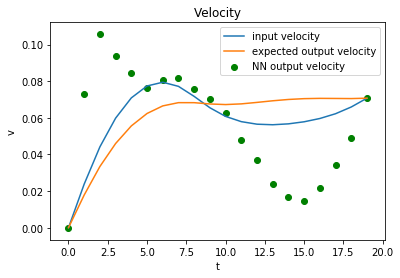

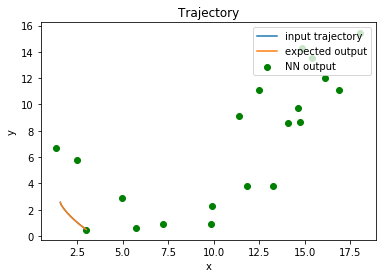

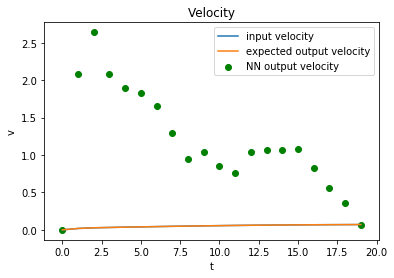

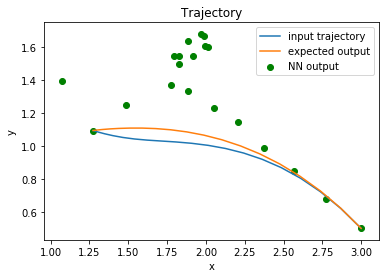

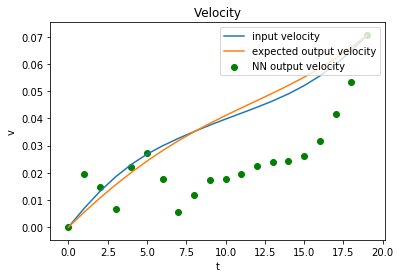

In [25]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


## Model with normalization- all iter

### Try training data

In [41]:
model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])

filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.p"
xMin, yMin, xRange, yRange = getDataParamsFromPickle(filename)

Idx = [0,1,2]
X_train_np_array=np.array(X_train)
NN_input = (X_train_np_array-xMin)/xRange
NN_output = model.predict(NN_input[Idx])
NN_output = NN_output*yRange + yMin

Training Examples


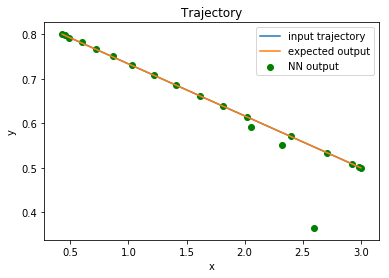

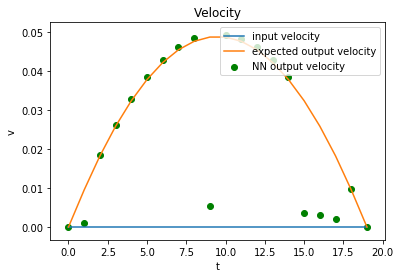

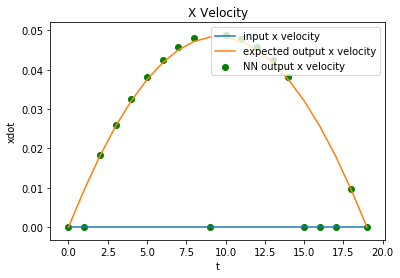

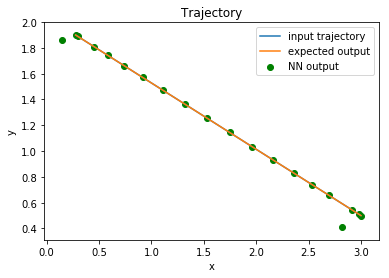

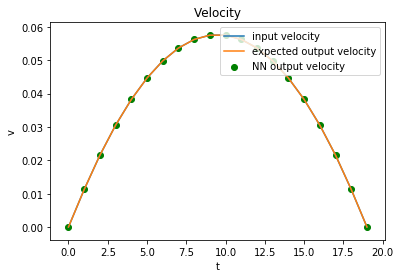

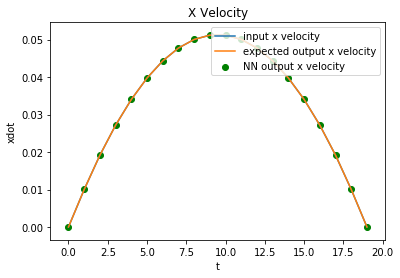

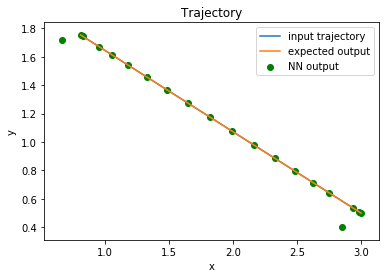

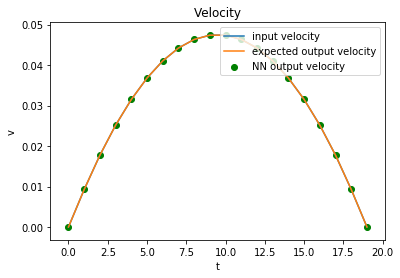

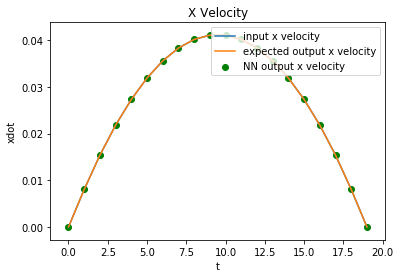

In [42]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotXVelocityInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])



### Try test data

In [28]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

(4, 180)
Test Examples


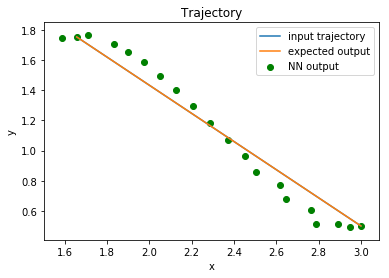

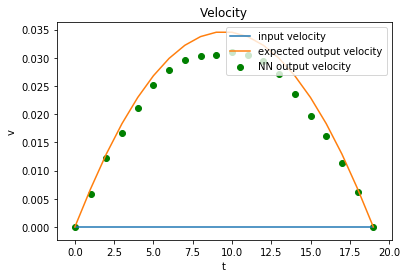

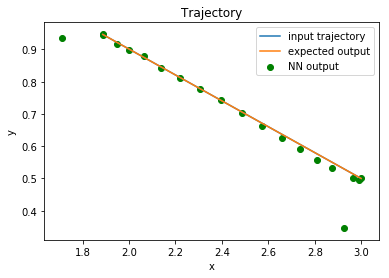

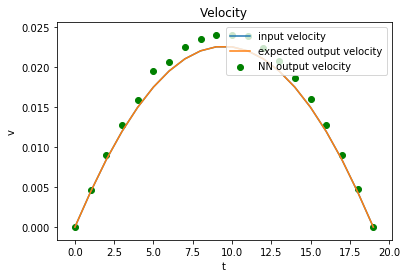

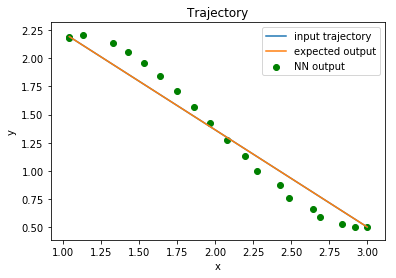

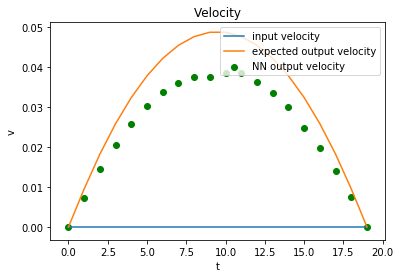

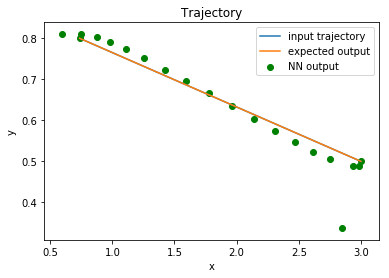

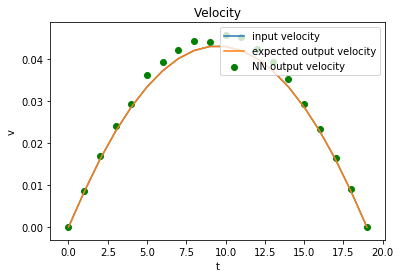

In [29]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


## Model with normalization- only first iter

### Try training data

In [26]:
model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterNormalizedA.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
f = open( "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterParams.p", "rb" )
params_dict = pickle.load(f)         
f.close() 
xMin = params_dict["xMin"]
yMin = params_dict["yMin"]
xRange = params_dict["xRange"]
yRange = params_dict["yRange"]


Idx = [0,1,2]
X_train_np_array=np.array(X_train)
NN_input = (X_train_np_array-xMin)/xRange
NN_output = model.predict(NN_input[Idx])
NN_output = NN_output*yRange + yMin

Training Examples


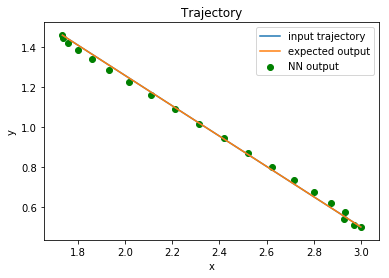

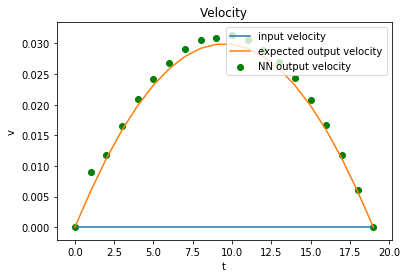

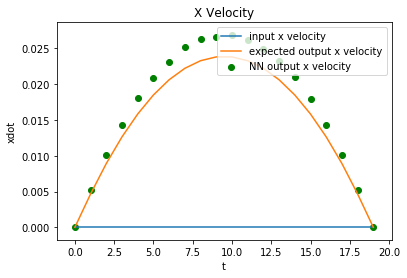

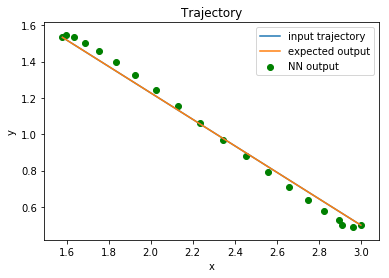

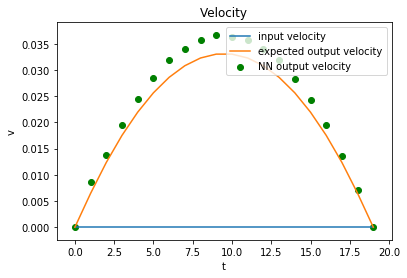

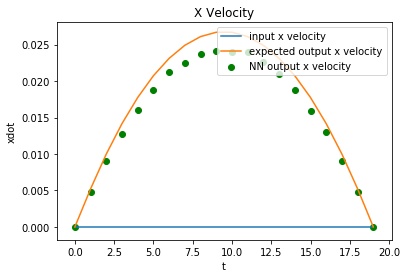

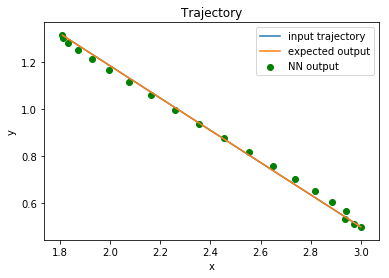

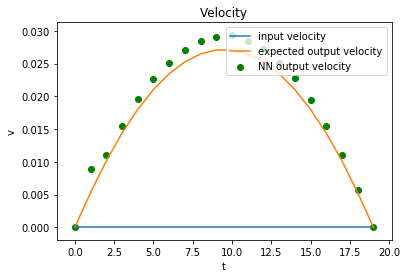

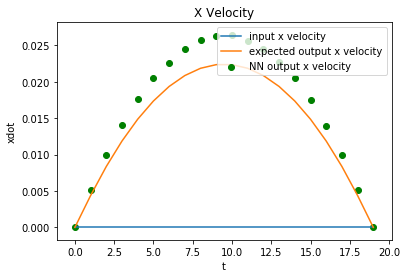

In [27]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotXVelocityInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])



### Try test data

In [28]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

(4, 180)
Test Examples


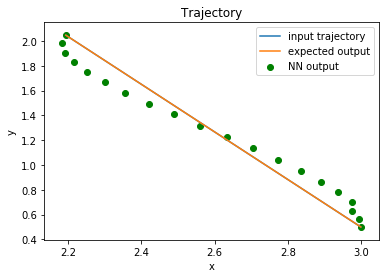

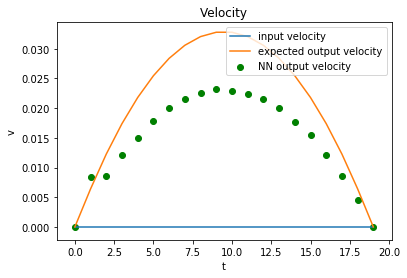

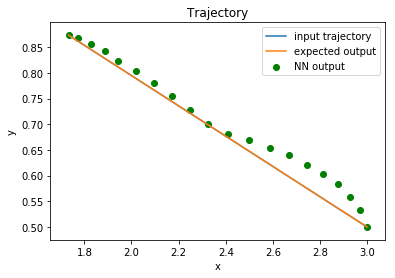

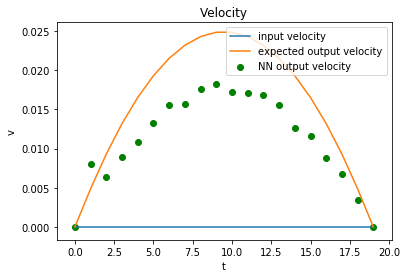

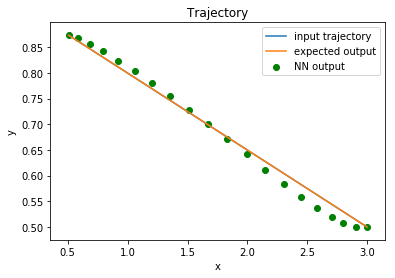

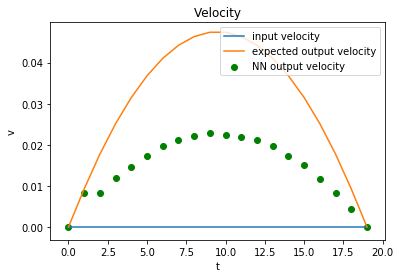

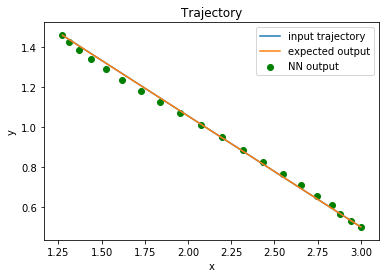

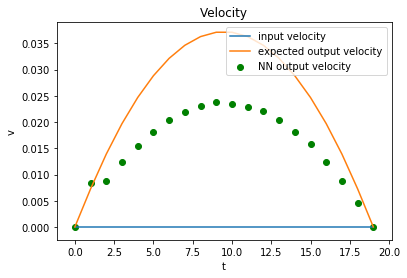

In [29]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


## Newer model, bigger network, first iteration only

### Try training data

In [25]:
# model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

Idx = [0,1,2]
X_train_np_array=np.array(X_train)
NN_input = (X_train_np_array-xMin)/xRange
NN_output = model.predict(NN_input[Idx])
NN_output = NN_output*yRange + yMin

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training Examples


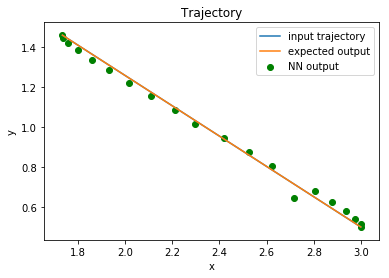

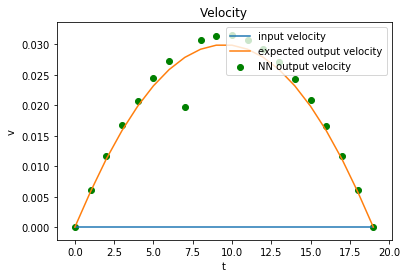

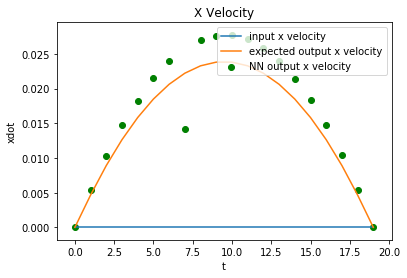

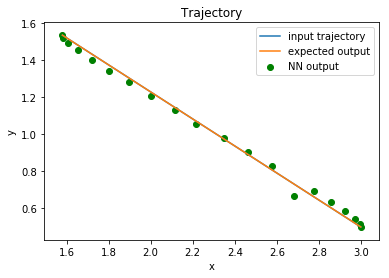

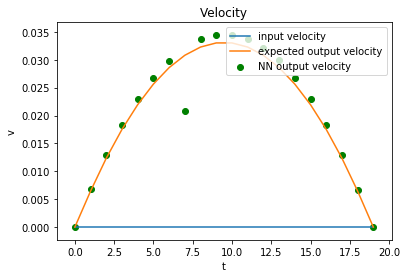

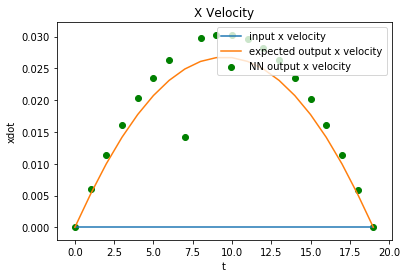

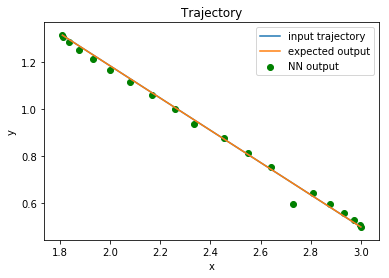

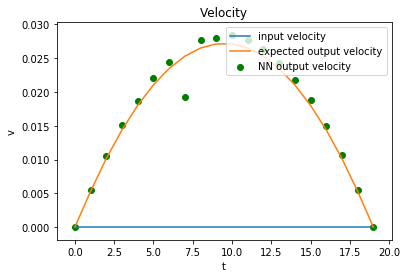

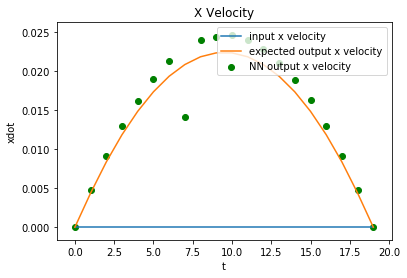

In [26]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotXVelocityInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])



### Try test data

In [27]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

(4, 180)
Test Examples


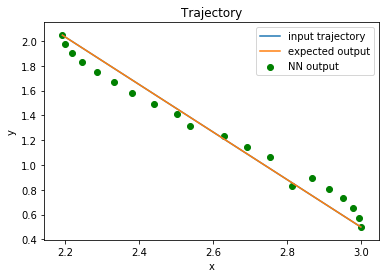

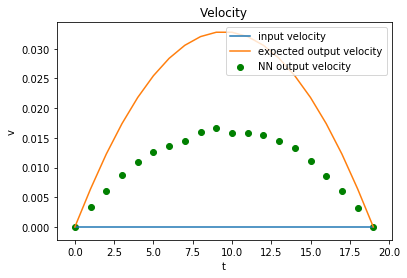

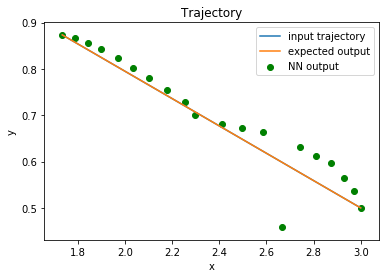

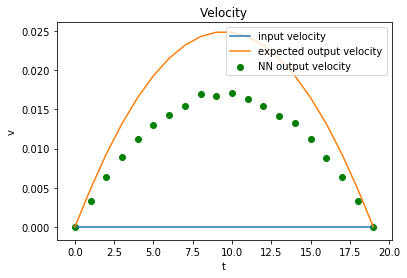

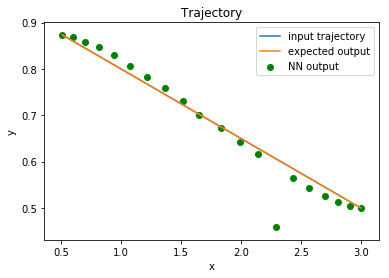

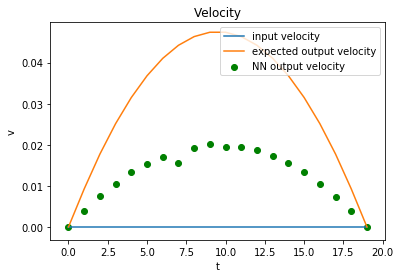

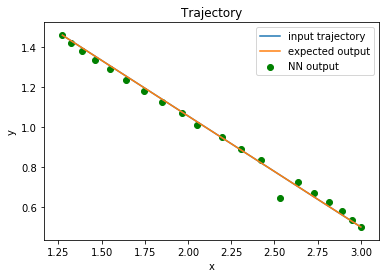

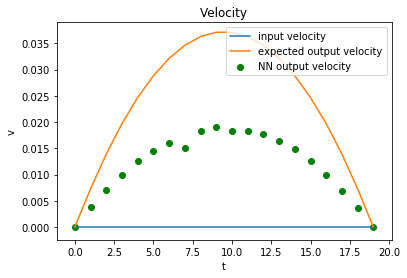

In [28]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


In [37]:
for i in range(np.size(model.layers,0)):
    print(model.layers[i]).get_weights()
    

AttributeError: 'NoneType' object has no attribute 'get_weights'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_449 (Dense)            (None, 512)               93696     
_________________________________________________________________
dense_450 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_451 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_452 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_453 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_454 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_455 (Dense)            (None, 512)               524800    
__________

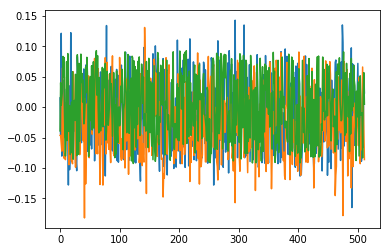

In [69]:
print(model.summary())
wts0 = model.get_layer(index = 0).get_weights()[0]
# print(np.shape(wts0))
# print(np.shape(wts0[0]))
# print(np.shape(wts0[1]))
print(wts0.shape)
# print(np.shape(np.squeeze(wts0)))
plt.plot(wts0[0])
plt.plot(wts0[1])
plt.plot(wts0[2])

plt.show()

In [70]:
print(wts0[wts0==0])
# So none of the weights are 0

[]


(512, 180)


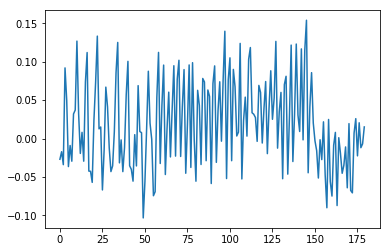

[]


In [73]:
wts9 = model.get_layer(index = 9).get_weights()[0]
print(wts9.shape)
plt.plot(wts9[0])
plt.plot(wts9[1])
plt.plot(wts9[2])
plt.show()
print(wts9[wts9==0])
# None of these weights are 0 either.

# Helper functions below

## Load data and create test and training inputs and outputs

In [14]:
# filenames must be a list
def loadData(filenames, testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"]):
    # load simple dataset
    for i, filename in enumerate(filenames):
        PATH_FILE_TRAINING3 = os.getcwd()+"/"+filename
        f = h5py.File(PATH_FILE_TRAINING3, "r")
        # split into input and output variables
        if i==0:
            X       = f[fieldNames[0]].value;     
            X      = X.transpose();
            Y        = f[fieldNames[1]].value;      
            Y       = Y.transpose();
        else:
            X1       = f[fieldNames[0]].value;     
            X1      = X1.transpose();
            Y1        = f[fieldNames[1]].value;      
            Y1       = Y1.transpose();
            X = np.vstack((X,X1))
            Y = np.vstack((Y,Y1))   
    
    # split the data into training (75%) and testing (25%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=testRatio, random_state=seed)

    # Examine shape of data
#     print(np.shape(X))
#     print(np.shape(Y))
#     print(np.shape(X_train))
#     print(np.shape(X_test))
#     print(np.shape(Y_train))
#     print(np.shape(Y_test))
    return X_train, X_test, Y_train, Y_test



## Create custom metric to print learning rate after each epoch

In [15]:
class CustomMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = K.eval(self.model.optimizer.lr)
        lrHist.append(current_lr)
        print("Learning rate: ",current_lr)
#     def on_batch_end(self, batch, logs):
#         weights, _biases = model.get_weights()
#         w1, w2 = weights
#         weights = [w1[0], w2[0]]
#         print('on_batch_end() model.weights:', weights)
#         weights_history.append(weights)

## Function to plot trajectory from row of training data

In [16]:
def plotTrajectoryFromInput(X_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    x = X_data[0:120:6] 
    y = X_data[1:120:6]
#     print(np.shape(x))
#     print(np.shape(y))
    plt.plot(x, y)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [17]:
def plotTrajectoryInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
    print(np.shape(xIn))
    print(np.shape(yIn))
    
    xOut = xIn + Y_data[0:120:6]
    yOut = yIn + Y_data[1:120:6]
    print(np.shape(xOut))
    print(np.shape(yOut))
    
    plt.plot(xIn, yIn)
    plt.plot(xOut, yOut)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output'], loc='upper right')
    plt.show()

In [18]:
def plotVelocitiesInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotOut = np.array(xDotIn + Y_data[3:120:6])
    yDotOut = np.array(yDotIn + Y_data[4:120:6])
    velOut = np.sqrt(xDotOut**2 + yDotOut**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    
    plt.plot(velIn)
    plt.plot(velOut)
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity'], loc='upper right')
    plt.show()

In [19]:
def plotTrajectoryInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xExp = xIn + Y_data[0:120:6]
    yExp = yIn + Y_data[1:120:6]
#     print(np.shape(xOut))
#     print(np.shape(yOut))

    xNN = xIn + NN_data[0:120:6]
    yNN = yIn + NN_data[1:120:6]
    
    plt.plot(xIn, yIn)
    plt.plot(xExp, yExp)
    plt.scatter(xNN, yNN,color='g')
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output', 'NN output'], loc='upper right')
    plt.show()

In [20]:
def plotVelocitiesInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotExp = np.array(xDotIn + Y_data[3:120:6])
    yDotExp = np.array(yDotIn + Y_data[4:120:6])
    velExp = np.sqrt(xDotExp**2 + yDotExp**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    xDotNN = np.array(xDotIn + NN_data[3:120:6])
    yDotNN = np.array(yDotIn + NN_data[4:120:6])
    velNN = np.sqrt(xDotNN**2 + yDotNN**2)
    
    plt.plot(velIn)
    plt.plot(velExp)
    plt.scatter(np.arange(np.size(velNN,0)), velNN,color='g')
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity', 'NN output velocity'], loc='upper right')
    plt.show()

In [21]:
def plotXVelocityInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
#     yDotIn = np.array(X_data[4:120:6])
#     velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotExp = np.array(xDotIn + Y_data[3:120:6])
#     yDotExp = np.array(yDotIn + Y_data[4:120:6])
#     velExp = np.sqrt(xDotExp**2 + yDotExp**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    xDotNN = np.array(xDotIn + NN_data[3:120:6])
#     yDotNN = np.array(yDotIn + NN_data[4:120:6])
#     velNN = np.sqrt(xDotNN**2 + yDotNN**2)
    
    plt.plot(xDotIn)
    plt.plot(xDotExp)
    plt.scatter(np.arange(np.size(xDotNN,0)), xDotNN,color='g')
    plt.title('X Velocity')
    plt.ylabel('xdot')
    plt.xlabel('t')
    plt.legend(['input x velocity', 'expected output x velocity', 'NN output x velocity'], loc='upper right')
    plt.show()

In [33]:
def plotLagrangeInputExpectedAndNN(X_dual, Y_dual, NN_dual):
    # X_dual, Y_dual, and NN_dual have shape (n,6) 
    X_dual_norms = np.linalg.norm(X_dual, axis = 1)
    Y_dual_norms = np.linalg.norm(X_dual, axis = 1)
    NN_dual_norms = np.linalg.norm(X_dual, axis = 1)
    
    xs = range(1,np.size(X_dual,0)+1)
    plt.scatter(xs, X_dual_norms, color='b',marker='s')
    plt.scatter(xs, Y_dual_norms, color='r',marker='o')
    plt.scatter(xs, NN_dual_norms, color='g', marker='^')
    plt.title('Dual norm deviation from expected')
    plt.ylabel('norm of dual vector')
    plt.xlabel('iteration')
    plt.legend(['input dual vector', 'expected output dual vector', 'NN output dual vector'], loc='upper right')
    plt.show()

In [49]:
def plotLagrangeInputExpectedAndNNSingle(X_dual, Y_dual, NN_dual):
    # X_dual, Y_dual, and NN_dual have shape (1,6) 
    xs = range(1,7)
    plt.scatter(xs, X_dual, color='b',marker='o', s = 50)
    plt.scatter(xs, Y_dual, color='r',marker='s', s = 30)
    plt.scatter(xs, NN_dual, color='g', marker='^', s = 20)
    plt.title('Dual vector components deviation from expected')
    plt.ylabel('real value')
    plt.xlabel('components of dual vector')
    plt.legend(['input dual vector', 'expected output dual vector', 'NN output dual vector'], loc='lower left')
    plt.show()

## Functions to get data parameters xMin, xRange, etc from files

In [24]:
def getDataParamsFromPickle(filename):
    import pickle
    f = open(filename, "rb" )
    params_dict = pickle.load(f)         
    f.close() 
    xMin = params_dict["xMin"]
    yMin = params_dict["yMin"]
    xRange = params_dict["xRange"]
    yRange = params_dict["yRange"]
    return xMin, yMin, xRange, yRange

In [25]:
def getDataParamsFromHDF5(filename):
    hf = h5py.File(filename, "r")
    xMin = np.array(hf.get("xMin"))
    yMin = np.array(hf.get("yMin"))
    xRange = np.array(hf.get("xRange"))
    yRange = np.array(hf.get("yRange"))
    hf.close() 
    return xMin, yMin, xRange, yRange

In [26]:
def saveDataParamsToHDF5(filename, xMin, yMin, xRange, yRange):
    # Save these params into an h5 file
    hf = h5py.File(filename, 'w')
    hf.create_dataset("xMin", data = xMin)
    hf.create_dataset("yMin", data = yMin)
    hf.create_dataset("xRange", data = xRange)
    hf.create_dataset("yRange", data = yRange)
    hf.close()

In [27]:
def saveDataParamsToPickle(filename, xMin, yMin, xRange, yRange):
    # Save a dictionary of xMin, xRange, yMin, yRange into a pickle file.
    import pickle
    data_params = { "xMin": xMin, "xRange": xRange, "yMin": yMin, "yRange": yRange }
    f = open( filename, "wb" )
    pickle.dump(data_params, f,-1)
    f.close() 

## Normalize dataset

In [28]:
def normalize_datasets(X_train, X_test, Y_train, Y_test):
    # Normalize all datasets to be between [0,1]
    X = np.vstack([X_train, X_test])
    Y = np.vstack([Y_train, Y_test])

    xMin = np.amin(X, axis=0)
    xMax = np.amax(X, axis=0)
    xRange = xMax - xMin
    xRange[xRange == 0] = 1.0
    xRange[abs(xRange) <1.0e-20]=1.0
    X_train = (X_train-xMin)/xRange
    X_test = (X_test-xMin)/xRange

    yMin = np.amin(Y, axis=0)
    yMax = np.amax(Y, axis=0)
    yRange = yMax - yMin
    yRange[yRange == 0] = 1.0
    yRange[abs(yRange) <1.0e-20]=1.0
    Y_train = (Y_train-yMin)/yRange
    Y_test = (Y_test-yMin)/yRange
    
    return (X_train, X_test, Y_train, Y_test, xMin, xRange, yMin, yRange)

# Scraps

In [ ]:
print("x values in output are: ",Y_train[0:120:6])
print("max x values in output are: ",np.max(Y_train[0:120:6]))

print("real x values in output are: ",Y_train_recov[0:120:6])
print("max real x values in output are: ",np.max(Y_train_recov[0:120:6]))


print("Training data")
for x in range(1):
    i = x
    print("Random i =",i)
    # Nope this plot doesn't make sense because Y and X are normalized differently. 
    # The plot function adds xIn to xOut which doesn't make sense due to different normalization factors.
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])
    X_train_recov = X_train * xRange + xMin
    Y_train_recov = Y_train * yRange + yMin
    plotTrajectoryInputAndOutput(X_train_recov[i,:],Y_train_recov[i,:])
    plotVelocitiesInputAndOutput(X_train_recov[i,:],Y_train_recov[i,:])

In [ ]:
test = np.array([ 0.00000000e+00 , 0.00000000e+00, -3.71207106e-28 , 1.52276790e-27,
  0.00000000e+00 ,-6.37509888e-02,  4.63915646e-02 , 0.00000000e+00,
  5.21828034e-03])
test[test==0]=1.0
test[abs(test) <1.0e-25]=1.0
print(test)